### Build a multiclass classifier for food images

In [1]:
import os
from keras_preprocessing.image import ImageDataGenerator 
from keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import SGD

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten, Input

from keras.applications.vgg16 import VGG16
from keras.applications.efficientnet_v2 import EfficientNetV2
import os
import shutil
import argparse

from keras.callbacks import ModelCheckpoint

In [2]:
DATASET = "./datasets/food-101/images/"

### Look at the dataset

In [3]:
from matplotlib import pyplot as plt
from matplotlib.image import imread

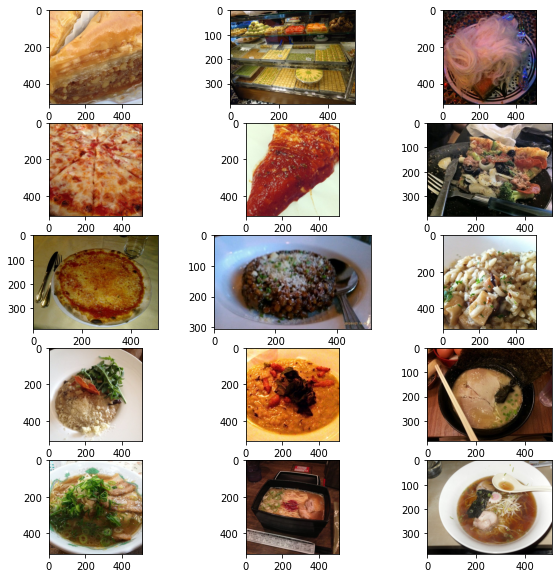

In [4]:
plt.figure(figsize=(10,10))

count = 1 
for className in os.listdir(DATASET):
    if count >= 15:
        break
    for file in os.listdir('/'.join([DATASET, className])):
        plt.subplot(5,3,count)
        filepath = '/'.join([DATASET, className, file])
        img = imread(filepath)
        plt.imshow(img)
        count +=1
        if count % 4 == 0: break

In [5]:

args = argparse.Namespace()
#data argumentation
args.rescale = 1.0/255.0
args.shear_range = 0.2
args.zoom_range = 0.2
args.horizontal_flip = False,
args.validation_split = 0.2

#generating dataset for training and validating 
args.training_dataset = DATASET
args.target_size = (224,224)
args.batch_size = 128 
args.class_mode = 'categorical'

In [6]:
def create_dataset(args):
    train_gen = ImageDataGenerator(
        rescale = args.rescale,
        shear_range= args.shear_range,
        zoom_range= args.zoom_range,
        horizontal_flip= args.horizontal_flip,
        validation_split= args.validation_split 
    )

    train_dataset = train_gen.flow_from_directory(
        args.training_dataset,
        target_size= args.target_size,
        batch_size= args.batch_size,
        class_mode= args.class_mode,
        subset='training'
    )

    valid_dataset = train_gen.flow_from_directory(
        args.training_dataset,
        target_size= args.target_size,
        batch_size= args.batch_size,
        class_mode= args.class_mode,
        subset='validation'
    )

    return train_dataset, valid_dataset

def summarize_diagnostic(history, path = '', description = None):
    plt.figure(figsize=(10,10))
    plt.figtext(0, 1, description, fontsize=15)
    plt.subplot(211)
    plt.title("Loss")
    plt.plot(history.history['loss'], color="blue", label="train loss")
    plt.plot(history.history['val_loss'], color="red", label="validation loss")
    plt.legend()
    plt.subplot(212)
    plt.title("Accuracy")
    plt.plot(history.history['accuracy'], color="blue", label="train accuracy")
    plt.plot(history.history['val_accuracy'], color="red", label="validation accuracy")
    plt.legend()
    if(path!= ''):
        plt.rcParams['savefig.facecolor'] = 'white'
        plt.savefig(path, dpi = 100, bbox_inches = 'tight')

In [7]:
training_data, valid_data = create_dataset(args)

args.training_data = training_data
args.validation_data = valid_data 
args.steps_per_epoch = len(training_data)
args.validation_steps = len(valid_data)

print("number of training steps: " + str(args.steps_per_epoch))
print("number of validation steps: " + str(args.validation_steps))


Found 80800 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.
number of training steps: 632
number of validation steps: 158


In [8]:
CLASS_SIZES = 101

# def compile_model(model):
#     model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss=categorical_crossentropy, metrics=['accuracy'])
#     return model

def base_vgg16(args):
    print(args.target_size)
    x = Input(shape=(224,224,3))
    model = VGG16(include_top=False, input_tensor=x)
    flat = Flatten()(model.layers[-1].output)
    classifier = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat)
    output = Dense(101, activation='sigmoid')(classifier)
    optimizer = SGD(learning_rate=args.learning_rate, momentum=args.momentum)

    model = Model(inputs=model.inputs, outputs=output)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'])
    return model

def train(model, args, checkpoint = True):
    checkpoint_path = './tmp/checkpoint' 
    model_checkpoint = ModelCheckpoint(
        filepath = checkpoint_path,
        save_weights_only=True,
        monitor = 'val_accuracy',
        mode='max',
        save_best_only=True
    )
    if checkpoint:
        return model.fit(
            args.training_data,
            steps_per_epoch = args.steps_per_epoch,
            validation_data = args.validation_data,
            validation_steps = args.validation_steps,
            epochs = args.epochs,
            verbose = args.verbose,
            workers = args.workers,
            callbacks = [model_checkpoint]
        )
    else:
        return model.fit(
            args.training_data,
            steps_per_epoch = args.steps_per_epoch,
            validation_data = args.validation_data,
            validation_steps = args.validation_steps,
            epochs = args.epochs,
            verbose = args.verbose,
            workers = args.workers,
        )

In [9]:
checkpoint_path = './tmp/checkpoint'

print(args)
# Trained for 34+ epochs, try changin learning rate to increase speed
args.epochs = 50 
args.verbose = 1
args.learning_rate = 0.01
args.momentum = 0.9
args.workers = 8

model = base_vgg16(args)
if(os.path.exists(checkpoint_path)):
    model.load_weights(checkpoint_path)

model.summary()
history = train(model, args)


Namespace(batch_size=128, class_mode='categorical', horizontal_flip=(False,), rescale=0.00392156862745098, shear_range=0.2, steps_per_epoch=632, target_size=(224, 224), training_data=<keras_preprocessing.image.directory_iterator.DirectoryIterator object at 0x7f7f2b85b910>, training_dataset='./datasets/food-101/images/', validation_data=<keras_preprocessing.image.directory_iterator.DirectoryIterator object at 0x7f7f2b85b8b0>, validation_split=0.2, validation_steps=158, zoom_range=0.2)
(224, 224)


2022-04-23 22:06:56.715445: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 22:06:56.740528: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 22:06:56.740668: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 22:06:56.741090: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

2022-04-23 22:07:01.518326: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-04-23 22:07:07.856185: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-23 22:07:07.856223: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-04-23 22:07:07.856232: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory

  4/632 [..............................] - ETA: 11:53 - loss: 3.1881 - accuracy: 0.2227

KeyboardInterrupt: 

In [ ]:
description_text = "\
    RESULTS:\
    model config: {}\n\
    learning_rate: {}\n\
    momentum: {}\n\
    epochs: {}\n\
    valid_accuracy: {}\n\
    valid_loss: {}\n".format("VGG16_trainable", 
    args.learning_rate, 
    args.momentum,
    args.epochs,
    history.history['val_accuracy'][-1],
    history.history['val_loss'][-1]
    )

print(description_text)
summarize_diagnostic(history, path='vgg16_trainable', description=description_text)